# NetVlad 까지 가는 Toy-project입니다. 
우선 파이토치에서부터 시작해서, NetVLAD 논문을 다시한번 확인해보고, 간단한 응용까지 구현해봅니다. 

torch가 설치되어있지 않다면, pip install torch 로 먼저설치해보자. torch vision도 설치 안되어있네.  
![torch](torch.png)

In [1]:
import torch
from torch import nn  #Neural network
from torch.utils.data import DataLoader #dataset을 불러들이는 라이브러리다. 
from torchvision import datasets  #Vision에 특화된 dataset이다. 다른 라이브러리로는 torchtext, torchaudio 등 도메인에 특화된 것들이 있다. 
from torchvision.transforms import ToTensor #텐서로 변환하기 위한 라이브러리

이제 학습에 필요한 Data를 받아보자.   
![dataDownload](download.png)

In [2]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

Training을 위한 데이터를 받았다면, 이제 test용 데이터도 받아보자. 자세히보면 파라미터 하나만 다르다. 

In [3]:
test_data = datasets.FashionMNIST(
    root = "test",  #다운로드 폴더네. 
    train = False,
    download = True,
    transform = ToTensor(),
)

받아지면 폴더가 몇개 생긴걸 볼 수 있다.  
![tree](./tree.png)

이제 DataLoader를 통해 데이터를 읽어들이자. 

In [4]:
batch_size = 64

In [5]:
train_dataloader = DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

In [6]:
for X,y in test_dataloader:
    print(f"Shape of X[N,C,H,W] : {X.shape}")
    print(f"Shape of y : {y.shape}{y.dtype}")
    break

Shape of X[N,C,H,W] : torch.Size([64, 1, 28, 28])
Shape of y : torch.Size([64])torch.int64


# 모델 만들기

Pytorch에서 신경망 모델은 '''nn.Module''' 을 상속받는 클래스를 생성하여 정의한다. __init__ 함수에서 신경망 계층을(Layer) 정의하고, forward 함수에서 신경망 데이터를 어떻게 전달할 것인지 지정한다. 가능한 경우 GPU 또는 MPS로 신경망을 이동시켜 연산을 가속한다. 

In [7]:
#학습에 사용할 CPU나 GPU, MPS장치를 얻자. 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"using {device}")

using cuda


device에서 cpu가 떴다. cuda toolkit 설치를 확인해보자. --> 해결 봄. 5080은 nvidia-590 의 open 드라이버를 권장한다... 오픈만 되네. 오탈자 잘보자. 중괄호가 아니다. 
![cuda_error](cuda_error.png)

In [30]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),   #Conv1
            nn.ReLU(),                 #Activ
            nn.Linear(512,512),        #Conv2
            nn.ReLU(),                 #Activ
            nn.Linear(512,10)          #Conv3
            # nn.ReLU(),                 #Activ
            # nn.Linear(64,10)          #Conv3
        )

    def forward(self, x):
        x = self.flatten(x)  #Activ
        logits = self.linear_relu_stack(x)     
        return logits

model = NeuralNetwork().to(device)
#tutorial 에서는 NeuralNetwork().to(device) 라고 되어있는데, 여기서는 지워야 돌아간다. 오타들때문에 그랬다. 잘 수정하자. 

print(model)



NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


모델이 정의되었으면, 이제 손실함수와 옵티마이저를 정의한다. 

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

#시각화를 위한 설정
result_accuracy = []
result_accuracy.append(0)
result_loss = []
result_loss.append(0)

이제 학습단계를 설정해보자. 

In [32]:
def train(dataloader, model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)

        #Prediction 오류 계산
        pred = model(X)
        loss = loss_fn(pred,y)

        #역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(),(batch+1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [34]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    result_accuracy.append(correct)
    result_loss.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 2.309901  [   64/60000]
loss: 2.295172  [ 6464/60000]
loss: 2.266313  [12864/60000]
loss: 2.255932  [19264/60000]
loss: 2.249127  [25664/60000]
loss: 2.224525  [32064/60000]
loss: 2.224824  [38464/60000]
loss: 2.200685  [44864/60000]
loss: 2.189038  [51264/60000]
loss: 2.153445  [57664/60000]
Test Error: 
 Accuracy: 43.5%, Avg loss: 2.149383 

Epoch 2
-------------------------------
loss: 2.157411  [   64/60000]
loss: 2.151746  [ 6464/60000]
loss: 2.084206  [12864/60000]
loss: 2.097770  [19264/60000]
loss: 2.060265  [25664/60000]
loss: 1.996758  [32064/60000]
loss: 2.021587  [38464/60000]
loss: 1.947850  [44864/60000]
loss: 1.946434  [51264/60000]
loss: 1.876444  [57664/60000]
Test Error: 
 Accuracy: 57.5%, Avg loss: 1.873948 

Epoch 3
-------------------------------
loss: 1.897982  [   64/60000]
loss: 1.878255  [ 6464/60000]
loss: 1.752188  [12864/60000]
loss: 1.794873  [19264/60000]
loss: 1.691284  [25664/60000]
loss: 1.641323  [32064/600

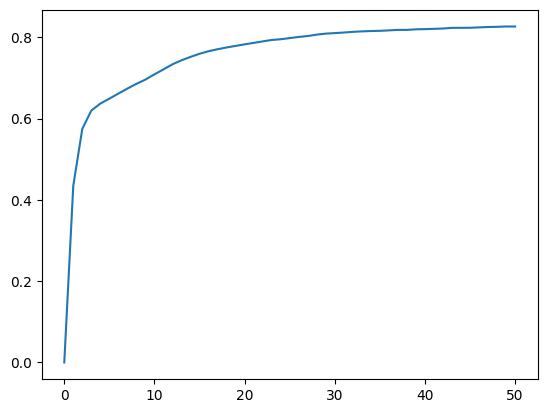

In [35]:
import matplotlib.pyplot as plt
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")
print(f"Accuracy : {result_accuracy}")
print(f"Loss : {result_loss}")
x = [i for i in range(len(result_accuracy))]
plt.plot(x,result_accuracy)
plt.show()

In [19]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


데이터셋을 한번 시각화해보자. 

In [ ]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
import numpy as np

def custom_imshow(img):
    img = img.numpy()
    print(len(img))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()




def process():
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        print(batch_idx)
        custom_imshow(inputs[0])


process()
